# Automates finis - TP 3

### Objectif du TP

   L'objectif de ce TP est d'implémenter des opérations régulières sur des automates finis. Ces opérations sont : la concaténation, l'union, et l'étoile de Kleene. Autrement dit, vous devrez créer trois fonctions, `concat(a1,a2)`, `union(a1,a2)` et `kleene(a1)` qui renvoient de nouveaux automates sur lesquels les opérations sont appliquées. Ces opérations seront ensuite utilisées au dernier TP pour créer un programme met ensemble tout le travail effectué jusqu'à présent, et qui reconnaîtra si un mot est décrit par une expression régulière. Ce prochain et dernier TP nécessitera de transformer l'expression régulière en automate fini avec l'algorithme de Thompson, ce qui requiert les trois opérations que vous allez implémenter aujourd'hui.

### Étoile de Kleene

L'étoile de Kléene est une opération qui permet à un motif reconnu par un automate d'être repété à l'infini. Autrement dit, si l'automate `a1` reconnaît le facteur $\alpha$, la fonction `kleene(a1)` devra renvoyer un nouvel automate `a1star` qui reconnaît $\alpha^*$, c'est-à-dire la concaténation du facteur $\alpha$ avec lui-même un nombre quelconque de fois (y compris zéro). Supposons que `a1` soit un automate qui reconnaît tout simplement le mot _a_:

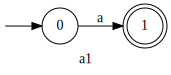

In [1]:
from automaton import Automaton, EPSILON
a1 = Automaton("a1")
source = """0 a 1
A 1
"""
a1.from_txt(source)
a1

Pour appliquer l'étoile de Kleene à `a1`, deux actions sont nécessaires. Premièrement, il faut rajouter des transitions-$\varepsilon$ depuis tous les états d'acceptation de `a1` vers l'état initial de `a1`. Pour éviter d'écraser `a1`, nous allons créer une copie que nous nommerons `a1star`:

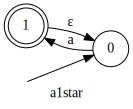

In [2]:
a1star = a1.deepcopy()
a1star.name = "a1star"
a1star.add_transition(a1star.acceptstates[0],EPSILON,a1star.initial.name)
a1star

Deuxièmement (et seulement après que la première étape soit finie), il faut créer un nouvel état initial. Veillez à bien vérifier que votre nouvel état initial n'existe pas encore dans l'automate. Pour obtenir cela, vous pouvez, par exemple, trouver le maximum parmi les noms d'états, puis incrémenter cette valeur. Par exemple, la fonction ci-dessous donne un nouveau numéro d'état à un automate quelconque donné en entrée :

In [3]:
def nouvel_etat(a1:Automaton)->str:
    """Trouve un nouveau nom d'état supérieur au max dans `a1`"""
    maxstate = -1
    for a in a1.states :
        try : maxstate = max(int(a),maxstate)
        except ValueError: pass # ce n'est pas un entier, on ignore
    return str(maxstate+1)

nom_nouvel_etat = nouvel_etat(a1star)
nom_nouvel_etat

'2'

Ce nouvel état initial doit être acceptant, avec une transition-$\varepsilon$ vers l'état initial original de `a1`, ce qui permet de reconnaître le mot vide $\varepsilon$ correspondant à l'auto-concaténation effectuée un nombre nul de fois :

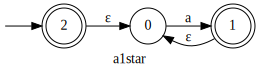

In [4]:
a1star.add_transition(nom_nouvel_etat,EPSILON,a1.initial.name)
a1star.initial = a1star.statesdict[nom_nouvel_etat]
a1star.make_accept(nom_nouvel_etat)
a1star

Ce nouvel automate `a1star` reconnaît _a*_ et est donc le résultat de `kleene(a1)`. Vous devez maintenant écrire cette fonction pour un automate `a1` quelconque, pas nécessairement celui donné dans cet exemple. Attention : cette fonction doit renvoyer un **nouvel** automate, et ne doit pas modifier celui qui est donné en paramètre (`a1`). Il faut donc faire une copie de l'automate passé en paramètre avant de le modifier, comme dans l'exemple ci-dessus, à l'aide de la fonction `deepcopy()`.

### Concaténation

La concaténation de deux automates `a1` et `a2` (dans cet ordre) est assez simple : il suffit de rajouter des transitions-$\varepsilon$ entre tous les états d'acceptation de `a1` vers l'état initial de `a2`, puis enlever les anciens états d'acceptation de `a1` de l'ensemble d'états d'acceptation du résultat. Supposons que un automate `a2` qui reconnaît uniquement le mot _b_:

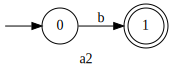

In [5]:
a2 = Automaton("a2")
a2.add_transition("0","b","1")
a2.make_accept("1")
a2

Maintenant, nous souhaitons concaténer `a1star` (qui reconnaît _a*_) avec `a2` (qui reconnaît _b_), pour créer un nouvel automate `a1star_a2` qui reconnaît _a*b_:

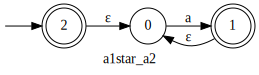

In [6]:
a1star_a2 = a1star.deepcopy()
a1star_a2.name = "a1star_a2"
a1star_a2

Il faut ensuite ajouter tous les états et transitions de `a2` à cette copie, mais en faisant attention à renommer les états qui seraient déjà présents dans `a1star_a2`:

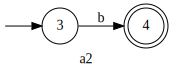

In [7]:
nom_nouvel_etat = nouvel_etat(a1star_a2)
for s in a2.states :
    if s in a1star_a2.states : # l'état de a2 existe dans la copie de a1star
        a2.rename_state(s,nom_nouvel_etat) # ici on modifie a2 directement -> à éviter
        nom_nouvel_etat = str(int(nom_nouvel_etat) + 1) # incrémente le compteur
a2

Maintenant que le renommage est effectué, nous pouvons ajouter tous les états et transitions de `a2` dans `a1star_a2` pour commencer à construire l'automate concaténé :

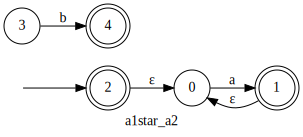

In [8]:
for (s,a,d) in a2.transitions:
    a1star_a2.add_transition(s,a,d)
a1star_a2.make_accept(a2.acceptstates)    
a1star_a2

Nous pouvons alors ajouter la transition-$\varepsilon$ depuis les états d'acceptation `2` et `1` de `a1star` vers l'état initial de `a2`:

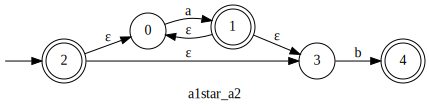

In [9]:
for ac in a1star.acceptstates:
    a1star_a2.add_transition(ac,EPSILON,a2.initial.name)
a1star_a2

Puis finalement garder uniquement les états d'acceptation de `a2` et faire en sorte que les anciens états d'acceptation de `a1star` (`2` et `1`) deviennent des états non acceptants:

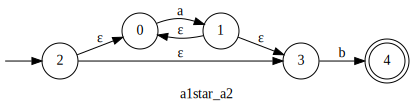

In [10]:
a1star_a2.make_accept(a1star.acceptstates, accepts=False) # transforme en états non acceptants
a1star_a2

Votre fonction `concat(a1,a2)` doit obtenir le résultat ci-dessus quand appliqué à `a1star` et `a2`, mais doit aussi donner un automate qui reconnaît la concaténation de deux autres automates quelconques, pas uniquement ceux-ci donnés en exemple.

### Union

La dernière opération à effectuer est l'union. Pour l'implémenter, nous allons créer un nouvel état initial qui mène aux états initiaux des deux automates à unir. Supposons que nous souhaitons unit l'automate ci-dessus `a1star_a2` qui reconnaît _a*b_ à un automate `a3` reconnaissant uniquement le mot _c_, de façon à créer un automate résultat `a1star_a2_or_a3` qui reconnaît _a*b+c_. Commençons par créer `a3` et la copie de `a1star_a2` qui contiendra le résultat :

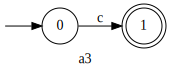

In [11]:
a3 = Automaton("a3")
a3.add_transition("0","c","1")
a3.make_accept("1")
a3

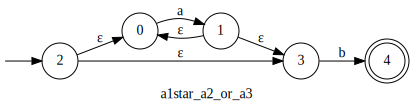

In [12]:
a1star_a2_or_a3 = a1star_a2.deepcopy()
a1star_a2_or_a3.name = "a1star_a2_or_a3"
a1star_a2_or_a3

Comme pour la concaténation, il faut commencer par mettre les états et transitions de `a3` dans le résultat, en renommant les états pour que chacun ait un nom unique :

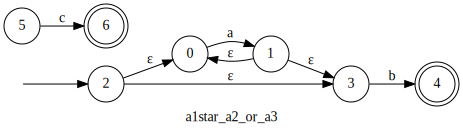

In [13]:
nom_nouvel_etat = nouvel_etat(a1star_a2_or_a3)
for s in a3.states :
    if s in a1star_a2_or_a3.states :
        a3.rename_state(s,nom_nouvel_etat) # ici on modifie a3 directement -> à éviter
        nom_nouvel_etat = str(int(nom_nouvel_etat) + 1) # incrémente le compteur
for (s,a,d) in a3.transitions:
    a1star_a2_or_a3.add_transition(s,a,d)
a1star_a2_or_a3.make_accept(a3.acceptstates)    
a1star_a2_or_a3

On peut désormais ajouter un nouvel état qui deviendra l'état initial. Il pointe vers les états initiaux de `a1star_a2` et `a3`:

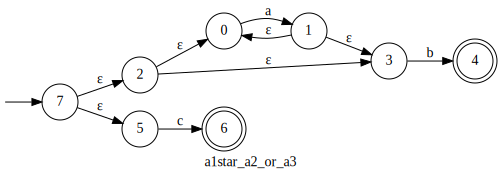

In [14]:
 # nom_nouvel_etat incrémenté plus haut -> on réutilise
a1star_a2_or_a3.add_transition(nom_nouvel_etat,EPSILON,a1star_a2.initial.name)
a1star_a2_or_a3.add_transition(nom_nouvel_etat,EPSILON,a3.initial.name)
a1star_a2_or_a3.initial = a1star_a2_or_a3.statesdict[nom_nouvel_etat]
a1star_a2_or_a3

Cet automate reconnaît _a*b+c_ et avec cet exemple nous finissons de voir les trois opérations à implémenter. La dernière constitue donc à implémenter l'union de deux automates quelconques `union(a1,a2)` pour générer un nouvel automate qui reconnaît le langage composé par l'union des langages reconnus par `a1` et par `a2`.

# Travail à effectuer

Vous devez implémenter les trois fonctions décrites ci-dessus dans un programme. Ces fonctions seront utilisées lors du prochain TP, mais pour les tester vous devez écrire un script de test `tp3automates.py` qui prend en entrée deux automates et affiche (sur le terminal, et/ou sous forme graphique dans un fichier PDF):
  * l'étoile de Kleene du premier (`kleene(a1)`)
  * la concaténation du premier avec le deuxième (`concat(a1,a2)`)
  * l'union du premier avec le deuxième (`union(a1,a2)`)

Comme d'habitude, un squelette de `tp3automates.py` est fourni sur le git comme un point de départ pour votre implémentation.

Par exemple :
```txt
$ ./tp3automates-correct.py test/a.af test/b.af 

a = <Q={0,1}, S={a}, D, q0=0, F={1}>
D =
| |a|
-----
|0|1|
-----
|1| |
-----

b = <Q={0,1}, S={b}, D, q0=0, F={1}>
D =
| |b|
-----
|0|1|
-----
|1| |
-----

kleene(a) = <Q={0,1,2}, S={a,%}, D, q0=2, F={2,1}>
D =
| |a|%|
-------
|0|1| |
-------
|1| |0|
-------
|2| |0|
-------

concat(a,b) = <Q={0,1,2,3}, S={a,%,b}, D, q0=0, F={3}>
D =
| |a|%|b|
---------
|0|1| | |
---------
|1| |2| |
---------
|2| | |3|
---------
|3| | | |
---------

union(a,b) = <Q={0,1,2,3,4}, S={a,b,%}, D, q0=4, F={1,3}>
D =
|     |a    |b    |%    |
-------------------------
|0    |1    |     |     |
-------------------------
|1    |     |     |     |
-------------------------
|2    |     |3    |     |
-------------------------
|3    |     |     |     |
-------------------------
|4    |     |     |{0,2}|
-------------------------
```

Un squelette de programme principal est donné dans `tp3automates.py`. Par rapport aux deux TP précédants, nous avons modifié le deuxième paramètre `sys.argv[2]` qui avant était le mot à reconnaître. Il pointe désormais vers le deuxième automate à lire à partir d'un fichier. N'oubliez pas de changer sur Spyder les options de la ligne de commande `Run -> Configurations per file...` Vous devez compléter les trois fonctions demandées dans le squelette `tp3automates.py` pour obtenir le résultat ci-dessus.